In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import uuid
import torch
import cv2
import os

In [2]:
# !tar -xf lfw.tgz

In [3]:
ANC_PATH = 'data/anchors/'
POS_PATH = 'data/positive/'
NEG_PATH = 'data/negative/'

In [4]:
# for directory in tqdm(os.listdir('lfw')):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         old_path = os.path.join('lfw', directory, file)
#         new_path = os.path.join(NEG_PATH, file)
#         os.replace(old_path, new_path)

In [5]:
# cap = cv2.VideoCapture(0)
# while cap.isOpened(): 
#     ret, frame = cap.read()
   
#     frame = frame[120:120+250,200:200+250, :]
    
#     if cv2.waitKey(1) & 0XFF == ord('a'):
#         imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#         cv2.imwrite(imgname, frame)
    
#     # Collect positives
#     if cv2.waitKey(1) & 0XFF == ord('p'):
#         imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         cv2.imwrite(imgname, frame)
    
#     cv2.imshow('Image Collection', frame)
    
#     if cv2.waitKey(1) & 0XFF == ord('q'):
#         break
        
# cap.release()
# cv2.destroyAllWindows()

In [6]:
print(len(os.listdir(ANC_PATH)))
print(len(os.listdir(POS_PATH)))

300
300


In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np

class FaceDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.load_images()
        self.make_pairs()
        
    def load_images(self):
        self.anchors = []
        self.positives = []
        self.negatives = []

        for anchor in tqdm(os.listdir(ANC_PATH), desc='Loading Anchor Images'):
            anchor_image = cv2.imread(os.path.join(ANC_PATH, anchor))
            anchor_image = cv2.cvtColor(anchor_image, cv2.COLOR_BGR2RGB)
            anchor_image = cv2.resize(anchor_image, (250, 250))
            self.anchors.append(anchor_image)

        for positive in tqdm(os.listdir(POS_PATH), desc='Loading Positive Images'):
            positive_image = cv2.imread(os.path.join(POS_PATH, positive))
            positive_image = cv2.cvtColor(positive_image, cv2.COLOR_BGR2RGB)
            positive_image = cv2.resize(positive_image, (250, 250))
            self.positives.append(positive_image)

        for negative in tqdm(os.listdir(NEG_PATH), desc='Loading Negative Images'):
            negative_image = cv2.imread(os.path.join(NEG_PATH, negative))
            negative_image = cv2.cvtColor(negative_image, cv2.COLOR_BGR2RGB)
            negative_image = cv2.resize(negative_image, (250, 250))
            self.negatives.append(negative_image)

    def make_pairs(self):
        self.data = []
        self.labels = []

        for anchor in tqdm(self.anchors, desc='Making Anchor-Positive Pairs'):
            for positive in self.positives:
                self.data.append([anchor, positive])
                self.labels.append(1)

        for anchor in tqdm(self.anchors, desc='Making Anchor-Negative Pairs'):
            for negative in self.negatives[:len(self.anchors)]:
                self.data.append([anchor, negative])
                self.labels.append(0)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        anchor, positive = self.data[idx]
        anchor = self.transform(anchor)
        positive = self.transform(positive)
        label = self.labels[idx]
        return anchor, positive, label

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

In [9]:
dataset = FaceDataset(transform=transform)

Making Anchor-Negative Pairs: 100%|██████████| 300/300 [00:00<00:00, 2438.86it/s]


In [10]:
BATCH_SIZE = 16

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1)


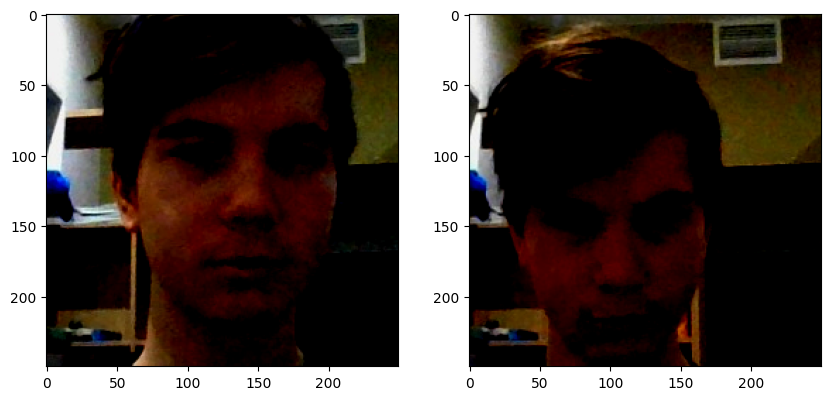

In [11]:
idx = 0
for batch in train_loader:
    anchor, positive, label = batch
    plt.figure(figsize=(10,10))
    print(label[idx])
    plt.subplot(1,2,1)
    plt.imshow(anchor[idx].permute(1, 2, 0))
    plt.subplot(1,2,2)
    plt.imshow(positive[idx].permute(1, 2, 0))
    plt.show()
    break

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=10)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=7)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=4)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=4)
        self.fc1 = nn.Linear(128 * 24 * 24, 1024)
        self.fc2 = nn.Linear(1024, 1)
        
    def forward_once(self, x):
        # print(x.shape)
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2)
        # print(x.shape)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2)
        # print(x.shape)
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=2, stride=2)
        # print(x.shape)
        x = F.relu(self.conv4(x))
        # print(x.shape)
        x = x.view(x.size()[0], -1)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        return x
    
    def forward(self, anchor, positive):
        output1 = self.forward_once(anchor)
        output2 = self.forward_once(positive)
        output = self.fc2(torch.abs(output1 - output2))
        return F.sigmoid(output)

model = SiameseNetwork()

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [14]:
from sklearn.metrics import accuracy_score

def train(epoch):
    progress_bar = tqdm(train_loader)
    losses = []
    accs = []
    model.train()
    for batch in progress_bar:
        anchor, positive, label = batch
        anchor, positive, label = anchor.to(device), positive.to(device), label.to(device)

        optimizer.zero_grad()

        output = model(anchor, positive)
        loss = criterion(output, label.reshape(-1, 1).float())

        losses.append(loss.item())
        accs.append(((output > 0.5) == label.reshape(-1, 1)).sum().item() / len(label))

        loss.backward()
        optimizer.step()

        progress_bar.set_description(f'Epoch {epoch} Loss: {np.mean(losses):.5f} Acc: {np.mean(accs):.5f}')

def validate(epoch):
    progress_bar = tqdm(val_loader)
    losses = []
    accs = []
    model.eval()
    for batch in progress_bar:
        anchor, positive, label = batch
        anchor, positive, label = anchor.to(device), positive.to(device), label.to(device)

        with torch.no_grad():
            output = model(anchor, positive)
            loss = criterion(output, label.reshape(-1, 1).float())

            losses.append(loss.item())
            accs.append(((output > 0.5) == label.reshape(-1, 1)).sum().item() / len(label))

            progress_bar.set_description(f'Validation Epoch {epoch} Loss: {np.mean(losses):.5f} Acc: {np.mean(accs):.5f}')
    
    return np.mean(losses)

In [15]:
EPOCHS = 2
best_loss = 1e9

for epoch in range(EPOCHS):
    train(epoch)
    loss = validate(epoch)
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), 'models/best_model.pt')

Validation Epoch 1 Loss: 0.51155 Acc: 0.97758: 100%|██████████| 2250/2250 [02:41<00:00, 13.91it/s]


In [16]:
best_model = SiameseNetwork()
best_model.load_state_dict(torch.load('models/best_model.pt'))
best_model.to(device)

SiameseNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(10, 10), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=73728, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [17]:
def preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (250, 250))
    image = transform(image)
    image = image.unsqueeze(0)
    return image

In [28]:
def verify(image, dir):
    image = preprocess(image).to(device)
    results = []
    model.eval()
    with torch.no_grad():
        for file in os.listdir(dir):
            img = cv2.imread(os.path.join(dir, file))
            img = preprocess(img).to(device)
            
            output = best_model(image, img)
            results.append(output.item())
    print(dir, results)
    return np.mean(results)

In [25]:
def recognize(image):
    people = {}
    for dir in os.listdir('verification_data'):
        people[dir] = verify(image, f'verification_data/{dir}')
    people = {k: v for k, v in sorted(people.items(), key=lambda item: item[1], reverse=True)}
    return people

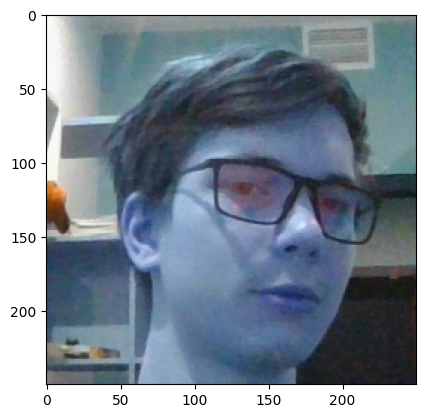

In [36]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

plt.imshow(frame)

In [37]:
recognize(frame)

verification_data/a.makarov@innopolis.university [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
verification_data/g.bush@innopolis.university [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


{'a.makarov@innopolis.university': 1.0, 'g.bush@innopolis.university': 0.0}